In [1]:
import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat_sim.utils.common import d3_40_colors_rgb

import gzip
import json
import random
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager
# font_manager.fontManager.addfont("~/miniconda3/envs/vlnce/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Arial-Bold.ttf")
# font_manager.fontManager.addfont("~/miniconda3/envs/vlnce/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Arial.ttf")
plt.rcParams['font.sans-serif'] = ["Arial"]
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from PIL import Image

import numpy as np
import pickle
import habitat
import seaborn as sns

In [2]:
def load_score(pkl_path="/home/ubuntu/MLA/score_save_single.pkl"):
    with open(pkl_path, "rb") as f:
        score_final = pickle.load(f)
    for k,v in score_final.items():
        s = score_final[k]["score"]
        score_final[k]["score"] = s/np.sum(s, axis=1, keepdims=True)
    score_success = {k:v for k, v in score_final.items() if v["infos"]["success"]==1 and len(v["score"])>0}
    score_fail = {k:v for k, v in score_final.items() if v["infos"]["success"]==0 and len(v["score"])>0}
    return score_success, score_fail
def load_action(pkl_path="/home/ubuntu/MLA/action_save_single.pkl"):
    with open(pkl_path, "rb") as f:
        action_final = pickle.load(f)
    return action_final

In [3]:
def read_data(suffix="val_seen"):
    s1, s2 = load_score("/home/ubuntu/MLA/score_%s.pkl"%(suffix))
    action_final = load_action("/home/ubuntu/MLA/action_%s.pkl"%(suffix))
    split = suffix.replace("ppo_","")
    sub_data_path = "/home/ubuntu/MLA/data/datasets/R2R_VLNCE_NRSub/%s/%s_sub.json.gz"%(split,split)
    with gzip.open(sub_data_path, "r") as f:
        sub_data = json.loads(f.read())
    sub_gt_path = "/home/ubuntu/MLA/data/datasets/R2R_VLNCE_NRSub/%s/%s_gt.json.gz"%(split,split)
    with gzip.open(sub_gt_path, "r") as f:
        sub_gt = json.loads(f.read())
    return s1, s2,sub_data,sub_gt

# Seen

In [4]:
success, fail, data, gt = read_data("ppo_val_seen")
episodes = {v["episode_id"]:v for v in data["episodes"]}
gt = {int(k):v for k, v in gt.items()}

In [5]:
print("Success num: %d"%(len(success)))
print("Fail num: %d"%(len(fail)))

def extract_path_info(info_data):
    pl = []
    step = []
    pl_gt = []
    step_gt = []
    for k, v in info_data.items():
        pl.append(v["infos"]["path_length"])
        step.append(v["infos"]["steps_taken"])
        pl_gt.append(episodes[k]["info"]["geodesic_distance"])
        step_gt.append(gt[k]["forward_steps"])
    return pl,step,pl_gt,step_gt

success_pl, success_step, success_pl_gt, success_step_gt = extract_path_info(success)
fail_pl, fail_step, fail_pl_gt, fail_step_gt = extract_path_info(fail)

Success num: 353
Fail num: 425


### Path length distribution

失败样本的真值路径比成功样本长，步数多

失败样本的实际路径长度没有很离谱，但步数有很多达到了500上限。成功样本也有少量达到了400步，接近上限

从残差图来看，失败样本步数要么比真值少很多，要么大很多。失败样本路径长度也一般在3m范围以外

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


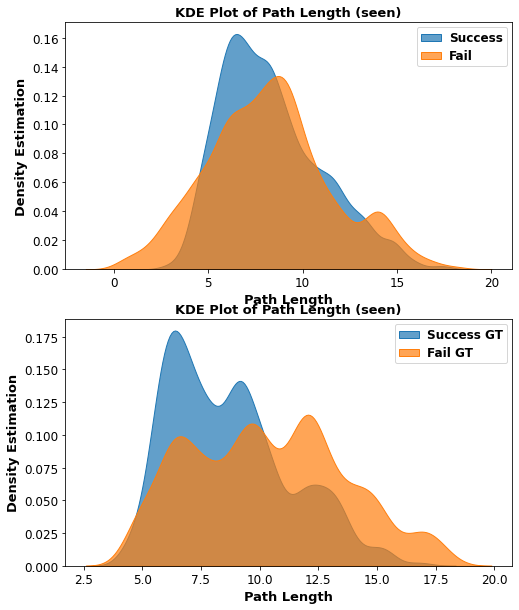

In [6]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')

ax = fig.add_subplot(212)
sns.kdeplot(success_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

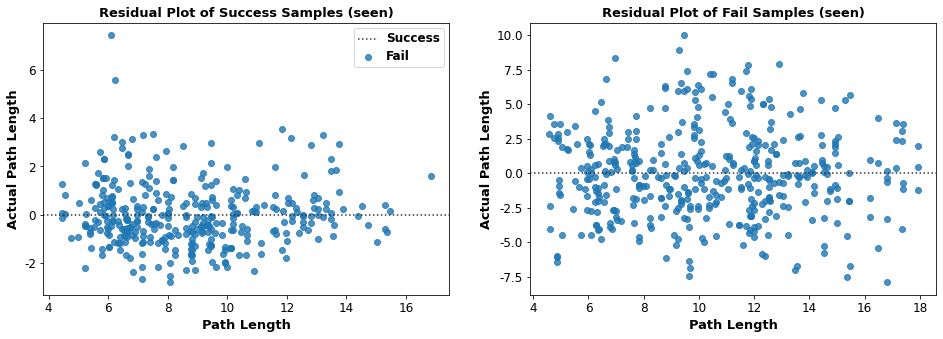

In [7]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
sns.residplot(x=success_pl_gt, y=success_pl, label="Cyl=4", )
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')


ax = fig.add_subplot(122)
sns.residplot(x=fail_pl_gt, y=fail_pl, label="Cyl=4", )
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

### Path steps distribution

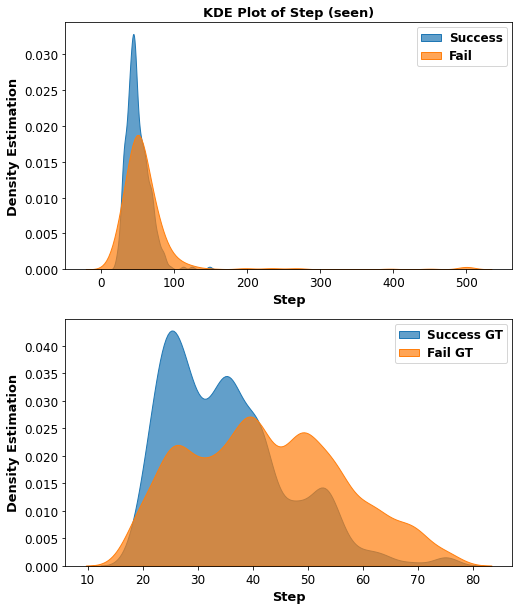

In [8]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step, "Fail": fail_step}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Step (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')


ax = fig.add_subplot(212)
sns.kdeplot(success_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step_gt, "Fail": fail_step_gt}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
# ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

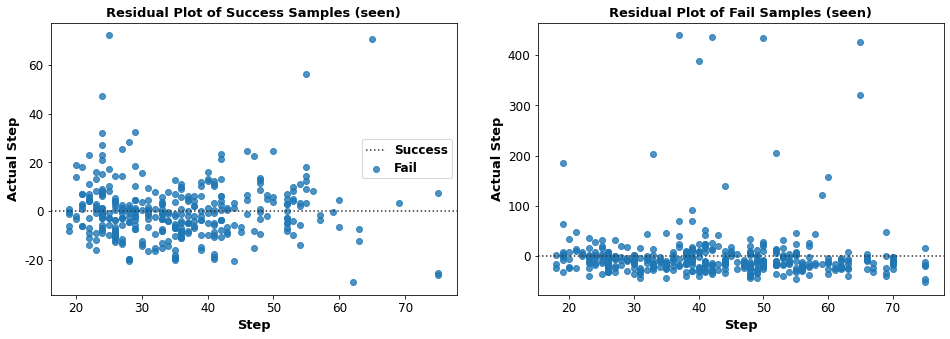

In [9]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
sns.residplot(x=success_step_gt, y=success_step, label="Cyl=4", )
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')


ax = fig.add_subplot(122)
sns.residplot(x=fail_step_gt, y=fail_step, label="Cyl=4", )
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

# Unseen

In [10]:
success, fail, data, gt = read_data("ppo_val_unseen")
episodes = {v["episode_id"]:v for v in data["episodes"]}
gt = {int(k):v for k, v in gt.items()}

In [11]:
print("Success num: %d"%(len(success)))
print("Fail num: %d"%(len(fail)))

def extract_path_info(info_data):
    pl = []
    step = []
    pl_gt = []
    step_gt = []
    for k, v in info_data.items():
        pl.append(v["infos"]["path_length"])
        step.append(v["infos"]["steps_taken"])
        pl_gt.append(episodes[k]["info"]["geodesic_distance"])
        step_gt.append(gt[k]["forward_steps"])
    return pl,step,pl_gt,step_gt

success_pl, success_step, success_pl_gt, success_step_gt = extract_path_info(success)
fail_pl, fail_step, fail_pl_gt, fail_step_gt = extract_path_info(fail)

Success num: 636
Fail num: 1203


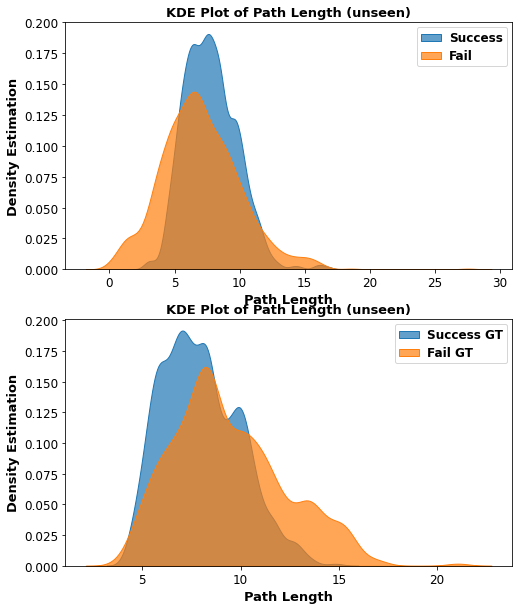

In [12]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')

ax = fig.add_subplot(212)
sns.kdeplot(success_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_pl_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Path Length (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

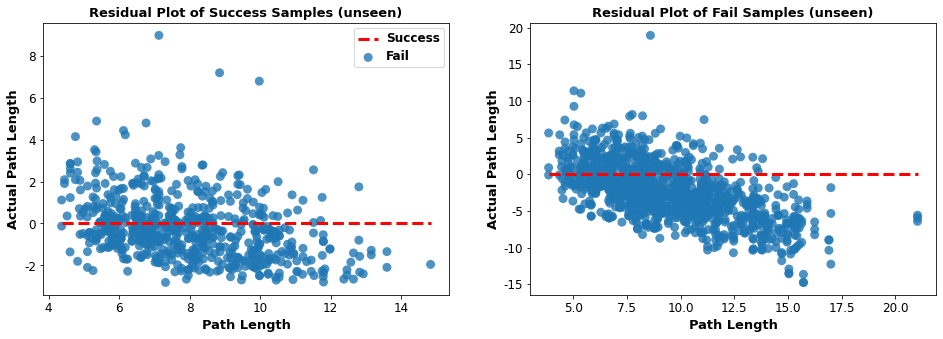

In [13]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
# sns.residplot(x=success_pl_gt, y=success_pl, label="Cyl=4", )
ax.scatter(x=success_pl_gt, y=np.array(success_pl)-np.array(success_pl_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(success_pl_gt), np.max(success_pl_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')


ax = fig.add_subplot(122)
# sns.residplot(x=fail_pl_gt, y=fail_pl, label="Cyl=4", )
ax.scatter(x=fail_pl_gt, y=np.array(fail_pl)-np.array(fail_pl_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(fail_pl_gt), np.max(fail_pl_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Path Length", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Path Length", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

### Path steps distribution

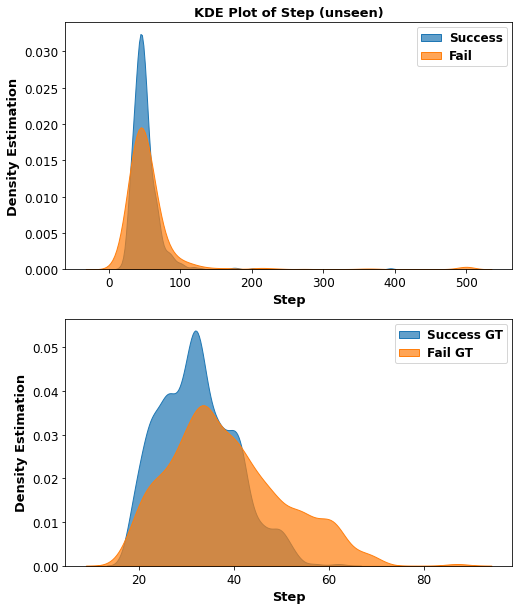

In [14]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(211)
sns.kdeplot(success_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step, "Fail": fail_step}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
ax.set_title("KDE Plot of Step (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success", "Fail"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')


ax = fig.add_subplot(212)
sns.kdeplot(success_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
sns.kdeplot(fail_step_gt, shade=True, label="Cyl=4", alpha=.7, gridsize=200, bw_method=0.2)
# c = [plt.cm.Spectral(i/1.0) for i in range(2)]
# sns.histplot({"Success": success_step_gt, "Fail": fail_step_gt}, ax=ax, kde=True, kde_kws={"gridsize": 100, "bw_method": 0.4}, line_kws={"linewidth":2}, zorder=1000)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Density Estimation", fontsize=13, fontweight='bold')
# ax.set_title("KDE Plot of Path Length (seen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
ax.legend(["Success GT", "Fail GT"])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
leg = ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold')
plt.show()

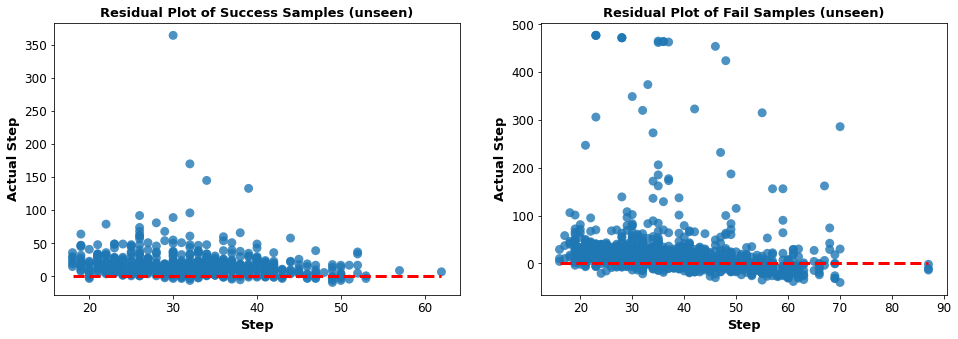

In [15]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
# sns.residplot(x=success_step_gt, y=success_step, label="Cyl=4",  lowess=True, line_kws=dict(color="r"))
# sns.scatterplot(x=success_step_gt, y=np.array(success_step)-np.array(success_step_gt),s=80, edgecolors='none', alpha=0.7)
ax.scatter(x=success_step_gt, y=np.array(success_step)-np.array(success_step_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(success_step_gt), np.max(success_step_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Success Samples (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )


ax = fig.add_subplot(122)
# sns.residplot(x=fail_step_gt, y=fail_step, label="Cyl=4", order=1, lowess=True, line_kws=dict(color="r"))
# sns.scatterplot(x=fail_step_gt, y=np.array(fail_step)-np.array(fail_step_gt))
ax.scatter(x=fail_step_gt, y=np.array(fail_step)-np.array(fail_step_gt), s=80, edgecolors='none', alpha=0.8)
ax.plot([np.min(fail_step_gt), np.max(fail_step_gt)],[0,0], c="r", linestyle="--", lw=3)
ax.set_xlabel("Step", fontsize=13, fontweight='bold')
ax.set_ylabel("Actual Step", fontsize=13, fontweight='bold')
ax.set_title("Residual Plot of Fail Samples (unseen)", fontsize=13, fontweight='bold')
# ax.set_xlim([0, 12])
plt.xticks(fontsize=12, ) 
plt.yticks(fontsize=12, )
# plt.savefig("cmp_sub_kde.pdf", bbox_inches='tight')
plt.show()

## Unseen fail samples, step analysis

In [16]:
avg_step = np.mean(success_step_gt+fail_step_gt)
print("Average steps: ", avg_step)
avg_pl = np.mean(success_pl_gt+fail_pl_gt)
print("Average length: ", avg_pl)

action_final = load_action("/home/ubuntu/MLA/action_%s.pkl"%("ppo_val_unseen"))

Average steps:  36.30668841761827
Average length:  8.899339109610578


In [17]:
# 步数小于或远超真值的比例
abnormal_id = []
for i,(k,v) in enumerate(fail.items()):
    if fail_step[i]-fail_step_gt[i]>fail_step_gt[i] or fail_step[i]-fail_step_gt[i]<-fail_step_gt[i]/4:
        # print(v)
        abnormal_id.append(k)
print("Propotion (abnormal steps / total fails)", len(abnormal_id)/len(fail))

Propotion (abnormal steps / total fails) 0.2950955943474647


In [18]:
# 到达上限的比例
exceed = []
for v in fail.keys():
    action = action_final[v]
    if len(action)>=499:
        exceed.append(v)
print("Propotion (exceed maximum / total fails)", len(exceed)/len(fail))

Propotion (exceed maximum / total fails) 0.00914380714879468


In [19]:
# 异常模式的比例
# 一次前进是0.25米，一次转向是15度
# 若前进100次则为25米，远超平均路径长度；若连续转向100次，则转了1500度，远超一圈
def stringfy(a):
    return " ".join([str(v) for v in a])
def find_recurrent(s, k, threshold=9):
    i = 0
    if i+k>=len(s):
        return False, None
    p = s[i:i+k]
    c = 0
    while i+k<len(s):
        if (s[i:i+k]==p).all():
            c += 1
        else:
            p = s[i:i+k]
            c = 1
        if c>=threshold:
            return True, p
        i += k
    return False, None
def is_recurrent_pattern(s, lmin=2, lmax=5):
    for k in range(lmin,lmax+1,1):
        res, pattern = find_recurrent(s, k, threshold=int(100/k))
        if res:
            return res, pattern
    return False, None
ab_pattern = []
for v in exceed:
    # s = stringfy(action_final[v])
    res, pattern = is_recurrent_pattern(action_final[v])
    # print(s)
    if res:
        ab_pattern.append((v, pattern))
print("Propotion (abnormal pattern / total fails)", len(ab_pattern)/len(fail))
print("Propotion (abnormal pattern / exceed)", len(ab_pattern)/len(exceed))

Propotion (abnormal pattern / total fails) 0.004987531172069825
Propotion (abnormal pattern / exceed) 0.5454545454545454


In [20]:
unique_patterns = [tuple(v[1]) for v in ab_pattern]
unique_patterns = set(unique_patterns)
print(unique_patterns)

{(1, 1), (2, 2)}


In [21]:
# 过少步数
short = []
for i,(k,v) in enumerate(fail.items()):
    if fail_step[i]-fail_step_gt[i]<-fail_step_gt[i]/4:
        # print(action_final[k])
        short.append(k)
print("Portion (too short / total fails)", len(short)/len(fail))

Portion (too short / total fails) 0.10806317539484622


In [22]:
a = set([v[0] for v in ab_pattern])
b = set(short)
a&b

set()

1. 过早stop
2. 重复多次的异常模式

比起IL，PPO的错误样本路径和步数普遍更短

比起IL，PPO错误样本中，极端步数更少，几乎不存在达到步数上限的样本，过短的比例更高

也就说明PPO训练在学习stop这一件事上做得更好，而且较少训练出震荡重复的动作

In [23]:
exceed = []
for v in fail.keys():
    action = action_final[v]
    if len(action)==500:
        exceed.append(v)
        print(action)
print("Propotion (exceed maximum / total fails)", len(exceed)/len(fail))

Propotion (exceed maximum / total fails) 0.0


In [24]:
len(success_step)+len(fail_step)

1839

In [25]:
exceed = []
for v in fail.keys():
    action = action_final[v]
    if len(action)>400:
        print(v, len(action))

148 499
209 499
368 499
761 499
751 496
64 499
696 499
949 499
634 471
950 499
951 499
847 406
290 499
291 499


In [38]:
check_list = set(random.sample(fail.keys(),15))
check_inst = []
for ep in data["episodes"]:
    if ep["episode_id"] in check_list:
       check_inst.append((ep["episode_id"],ep["instruction"]["instruction_text"]))
for v in check_inst:
    print("Episode %d: \n%s"%(v[0],v[1]),end="\n\n")

Episode 167: 
Go through the doorway, past the dining table, and through the doorway into the large lobby area, waiting here. 

Episode 255: 
Leave the bedroom and go into the den and take your first right into a hallway. A the end of the hallway take a left and go into the sitting room on the right. 

Episode 382: 
Walk across the patio to the other wall. Stop at the edge of the patio near the brick wall and the pillar of brick. 

Episode 397: 
Turn completely around. Walk straight ahead through the doorway that is next to the giant urn. 

Episode 404: 
Walk straight across room to hall next to bench. Turn slight left into room at left and stop at table. 

Episode 411: 
Walk to the living room on the far side of the counter. Stop next to the end table next to the couch with the bookshelf on your right. 

Episode 673: 
Walk straight between the kitchen island and the black sofa into the room with the two white sofas facing each other. Stop next to the brown table between the two sofas.

In [36]:
check_inst

[(46,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (76,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (187,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (248,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (254,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (445,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (909,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (928,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (929,
  'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. '),
 (1373,
  'Exit the bedroom and turn left. Walk 

In [33]:
data["episodes"][0]["instruction"]

{'instruction_text': 'Exit the bedroom and turn left. Walk straight passing the gray couch and stop near the rug. ',
 'instruction_tokens': [816,
  2202,
  246,
  103,
  2300,
  1251,
  9,
  2384,
  2112,
  1588,
  2202,
  1009,
  549,
  103,
  2104,
  1437,
  2202,
  1856,
  9,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}